In [36]:
import torch
from torch import Size
import numpy as np 
from gpssm.models.components.gp import ExactGPModel, VariationalGP
import gpytorch
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def plot_predictions(train_x, train_y, test_x, pred_y):
    fig, axes = plt.subplots(dim_y, 1, figsize=(8,8))
    for i in range(dim_y):
        lower, upper = pred_y.confidence_region()
        lower = lower.detach()
        upper = upper.detach()
        axes[i].plot(train_x[:, 0], train_y[i], 'k*')

        idx = test_x[:, 0].argsort()
        axes[i].plot(test_x[idx, 0], pred_y.mean[i, idx], 'b')
        axes[i].fill_between(test_x[idx, 0], lower[i, idx], upper[i, idx], alpha=0.5)

        axes[i].legend(['Observed Data', 'Mean', 'Confidence'])
        axes[i].set_title('Observed Values (Likelihood)')

        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y_{}'.format(i))
    plt.show()
    
def plot_losses(losses):
    plt.figure(figsize=(8, 4))
    plt.plot(losses, 'k-')
    plt.xlabel('Iteration Number')
    plt.ylabel('Marginal Log-Likelihood')
    plt.show()

# Generate data

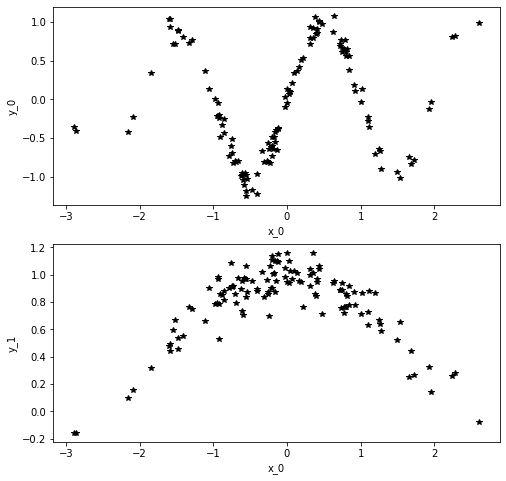

In [38]:
dim_x, dim_u = 2, 1
dim_y = dim_x
num_points = 128
batch_size = 32
decoupled_outputs = True
xu = torch.randn((num_points, dim_x + dim_u))

y1 = (torch.sin(np.pi * xu[:, 0]) + 0 * xu[:, 2] - 0 * xu[:, 1] ** 2).unsqueeze(dim=1)
y2 = (torch.cos(np.pi / 5 * xu[:, 0]) - 0 * xu[:, 2] ** 2 + 0 * xu[:, 1]).unsqueeze(dim=1)
y = torch.cat((y1, y2), dim=-1) + 0.1 * torch.randn((num_points, dim_y))

y = y[:, :dim_y]
y = y.t()

train_xu, test_xu = xu[:(num_points // 2)], xu[(num_points // 2):]
train_y, test_y = y[:, :(num_points // 2)], y[:, (num_points // 2):]

fig, axes = plt.subplots(dim_y, 1, figsize=(8,8))
for i in range(dim_y):
    axes[i].plot(xu[:, 0], y[i], 'k*')
    axes[i].set_xlabel('x_0')
    axes[i].set_ylabel('y_{}'.format(i))
    
plt.show()

# Exact GP Model 
 

In [21]:
# Set up likelihood, mean, and Kernel functions.
# likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(0.01, 0.02), batch_size=dim_y)
# mean = ConstantMean(batch_size=dim_y)
# kernel = ScaleKernel(RBFKernel(ard_num_dims=dim_x + dim_u, batch_size=dim_y), batch_size=dim_y)

likelihood = GaussianLikelihood(
    batch_size=dim_y,
    # noise_prior=gpytorch.priors.NormalPrior(0.1, 0.1)
)
mean = ConstantMean(batch_size=dim_y)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dim_x + dim_u, 
                               batch_size=dim_y
                               # lengthscale_prior=gpytorch.priors.GammaPrior(0.01, 0.1)
                               ),
                     batch_size=dim_y
                     # outputscale_prior=gpytorch.priors.GammaPrior(0.2, 0.2)
                     )


# Initialize Model, Marginal Log-Likelihood, and Optimizer.
model = ExactGPModel(train_xu, train_y, likelihood, mean, kernel)
mll = ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters.
], lr=0.1)

def train(training_iter):
    # Set model and likelihood to training mode.
    model.train()
    likelihood.train()
    losses = []

    for i in range(training_iter):
        # Zero gradients from previous iteration.
        optimizer.zero_grad()

        # Output from model.
        pred_f = model(train_xu)

        # Calc loss and backprop gradients.
        loss = -mll(pred_f, train_y).sum()
        loss.backward()
        losses.append(loss.item())
        
        if i % 50 == 0:
            print('Iter {}/{} - Loss: {}'.format(i + 1, training_iter, loss.item()))
        optimizer.step()
    
    return losses 

def eval(test_x, test_y):
    # Set model and likelihood to evaluation mode.
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred_f = model(test_x) #.expand(dim_y, *test_data.shape))
        loss = -mll(pred_f, test_y).sum()
        pred_y = likelihood(pred_f)
        print('MLL call:', loss.item()) 
        print('Direct Computation:', -pred_y.log_prob(test_y).sum().item() / (num_points // 2))
    return likelihood(pred_f)
        
losses = train(200)
pred_y = eval(test_xu, test_y)

print(
    likelihood.noise_covar.noise.detach(),
    model.covar_module.outputscale.detach(),
    model.covar_module.base_kernel.lengthscale.detach(),
)

Iter 1/200 - Loss: 2.2135586738586426
Iter 51/200 - Loss: -0.9430900812149048
Iter 101/200 - Loss: -1.0724937915802002
Iter 151/200 - Loss: -1.1111576557159424
MLL call: -1.4791287183761597
Direct Computation: -1.4791287183761597
tensor([[0.0084],
        [0.0096]]) tensor([0.6310, 0.0818]) tensor([[[ 0.5676, 10.1259, 10.0689]],

        [[ 0.9559,  8.5045,  9.0768]]])


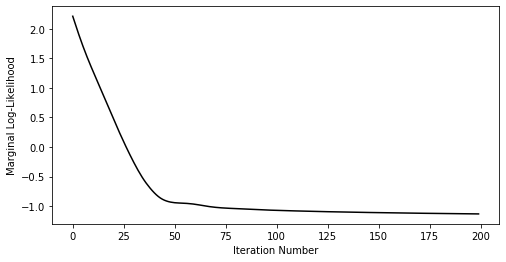

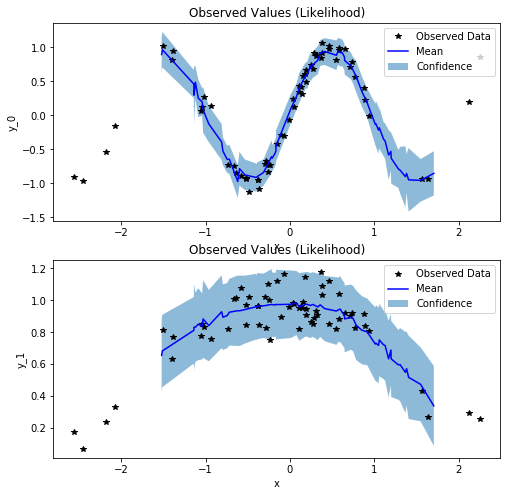

In [22]:
plot_losses(losses)
plot_predictions(train_xu, train_y, test_xu, pred_y)

# Variational GP Model 

In [51]:
num_inducing_points = 25
learn_inducing_loc = False
# inducing_points = torch.linspace(-2, 2, num_inducing_points).unsqueeze(-1).repeat(dim_y, 1, dim_x + dim_u)
inducing_points = torch.randn(dim_y, num_inducing_points, dim_x + dim_u)
# noise = torch.tensor([0.1]).expand(dim_y, 1, 1)
# print(noise.shape)
likelihood = GaussianLikelihood(
    batch_size=dim_y,
    # noise=noise
    # noise_prior=gpytorch.priors.GammaPrior(mean ** 2 / var, mean / var)
)
mean = ConstantMean(batch_size=dim_y,)
kernel = ScaleKernel(RBFKernel(
                                ard_num_dims=dim_x + dim_u, 
                               batch_size=dim_y,
                               # lengthscale_prior=gpytorch.priors.GammaPrior(0.01, 0.1)
                               ),
                     # outputscale_prior=gpytorch.priors.GammaPrior(10, 10),
                     batch_size=dim_y,
                     )
model = VariationalGP(inducing_points, mean, kernel, dim_y, learn_inducing_loc)

# hypers = {
#     # 'likelihood.noise_covar.noise': torch.tensor(1.),
#     'covar_module.base_kernel.lengthscale': torch.tensor(0.05),
#     'covar_module.outputscale': torch.tensor(1.),
# }
# 
# model.initialize(**hypers)
# likelihood.initialize(**{'noise_covar.noise': torch.tensor(0.1)})

print(
    likelihood.noise_covar.noise.detach(),
    model.covar_module.outputscale.detach(),
    model.covar_module.base_kernel.lengthscale.detach(),
)

optimizer = torch.optim.Adam([
    {'params': model.parameters()}, # Does not include gaussian likelihood.
    {'params': likelihood.parameters()} 
], lr=0.01)

mll = VariationalELBO(likelihood, model, train_y.size(-1), combine_terms=False)

def train(training_iter):
    # Set model and likelihood to training mode.
    model.train()
    likelihood.train()
    losses = []
    
    for i in range(training_iter):
        # Zero gradients from previous iteration.
        optimizer.zero_grad()
        
        # Output from model.
        output = model(train_xu)
        
        # Calc loss and backprop gradients
        log_lik, kl_div, log_prior = mll(output, train_y)
        loss = -(log_lik - kl_div + log_prior).mean()
        loss.backward()
        losses.append(loss.item())
        
        if i % 50 == 0:
            print('Iter %d - Loss: %.3f [%.3f, %.3f, %.3f]' % (
                i + 1, loss.item(), log_lik.mean().item(), kl_div.mean().item(),
                log_prior.mean().item()))
        optimizer.step()
    return losses 
        
# EVALUATE!
def eval(test_x, test_y):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_computations():
        pred_f = model(test_x) #test_x.expand(dim_y, *test_x.shape))
        pred_y = likelihood(pred_f)
        log_lik, kl_div, log_prior = mll(pred_f, test_y)
        loss = -(log_lik - kl_div + log_prior).mean()
        print('MLL call:', loss.item(), log_lik.detach(), kl_div.detach(),
              log_prior.detach())

        print('Direct Computation:', likelihood.expected_log_prob(test_y, pred_f).detach() / (num_points // 2))
        print('ExactLogLikelihood', likelihood(pred_f).log_prob(test_y).detach() / (num_points // 2))
        
        print('KL Divergence:', model.variational_strategy.kl_divergence() / (num_points // 2))
    
    return pred_y

losses = train(200)
pred_y = eval(test_xu, test_y)

tensor([[0.6932],
        [0.6932]]) tensor([0.6931, 0.6931]) tensor([[[0.6931, 0.6931, 0.6931]],

        [[0.6931, 0.6931, 0.6931]]])
Iter 1 - Loss: 1.640 [-1.640, 0.000, 0.000]
Iter 51 - Loss: 1.187 [-1.140, 0.047, 0.000]
Iter 101 - Loss: 0.937 [-0.865, 0.071, 0.000]
Iter 151 - Loss: 0.683 [-0.568, 0.115, 0.000]
MLL call: 0.39217472076416016 tensor([-0.3493, -0.0978]) tensor([0.2242, 0.1130]) tensor([0., 0.])
Direct Computation: tensor([-0.3493, -0.0978])
ExactLogLikelihood tensor([-0.2631, -0.0723])
KL Divergence: tensor([0.2242, 0.1130])


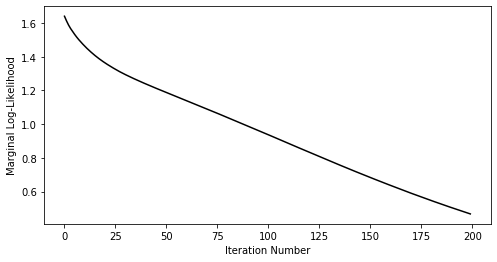

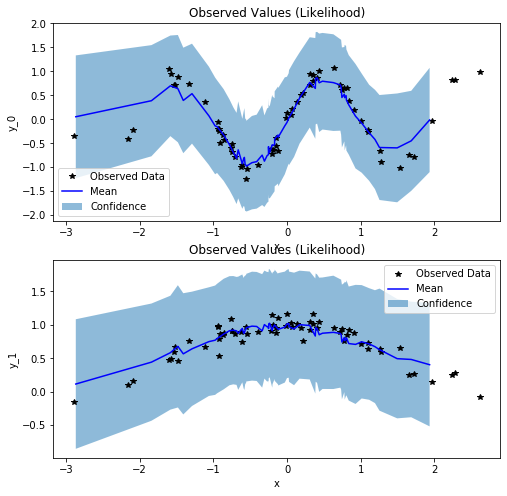

In [52]:
plot_losses(losses)
plot_predictions(train_xu, train_y, test_xu, pred_y)

# Sample Exact GP from Variational GP


In [53]:
sampled_model = model.sample_gp(likelihood)
sampled_model.eval()
likelihood.eval()

mll = ExactMarginalLogLikelihood(likelihood, sampled_model)

def eval(test_x, test_y):
    # Set model and likelihood to evaluation mode.
    sampled_model.eval()
    likelihood.eval()
    with torch.no_grad():
        pred_f = sampled_model(test_x) 
        pred_y = likelihood(pred_f)
        loss = -mll(pred_f, test_y).sum()
        print('MLL call:', loss.item()) 
        print('Direct Computation:', -pred_y.log_prob(test_y).sum().item() / (num_points // 2))
    return pred_y

pred_y = eval(test_xu, test_y)

MLL call: 0.5048589706420898
Direct Computation: 0.5048589706420898


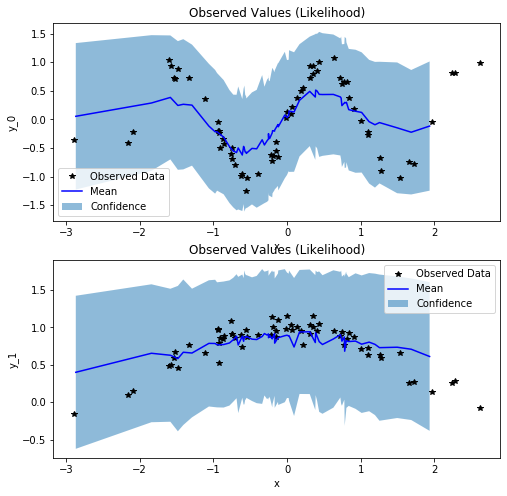

In [54]:
plot_predictions(train_xu, train_y, test_xu, pred_y)
